# Feature engineering for molecular structure (SMILES format)

- **Author**: senkin.zhan@datarobot.com
- **Sample data**: https://s3.us-east-1.amazonaws.com/datarobot_public_datasets/ai_accelerators/smiles.csv

## Summary

SMILES (Simplified molecular input line entry system) is a textual representation of molecular structures. While it's compact and widely used in cheminformatics, SMILES strings must be transformed into numerical representations to be used effectively in machine learning models.

This guide introduces a feature engineering pipeline tailored for SMILES-formatted molecular data. It demonstrates how to convert raw SMILES strings into machine-learning-ready features using RDKit and other tools.

This accelerator outlines how to:

1. Preprocess and visualize SMILES strings using RDKit and py3Dmol.
2. Extract molecular descriptors statistical features(physicochemical properties).
3. Extract TF-IDF features from SMILES strings, then apply TruncatedSVD to obtain lower-dimensional embeddings.
4. Extract fingerprints features from SMILES strings, then apply TruncatedSVD to obtain lower-dimensional embeddings.
5. Extract semantic representations from pretrained molecular embeddings of ChemBERTa and SMILESBERT, then apply PCA to obtain lower-dimensional embeddings.
6. Run DataRobot Autopilot with these features to compare model performance to create a benchmarks.
7. Extract feature contribution (SHAP values).

## Setup

### Install and import libraries

In [1]:
!pip install --upgrade pip -q
!pip install transformers py3Dmol rdkit torch jupyter ipywidgets jupyterlab_widgets -q

In [2]:
import os

import datarobot as dr
from datarobot.models.dataset import Dataset
from datarobot.models.modeljob import wait_for_async_model_creation
import numpy as np
import pandas as pd
import py3Dmol
from rdkit import Chem, DataStructs, RDLogger
from rdkit.Chem import AllChem, Descriptors, Draw
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import torch

os.environ["HF_HOME"] = os.environ.get("TRANSFORMERS_CACHE", "~/cache")
if "TRANSFORMERS_CACHE" in os.environ:
    del os.environ["TRANSFORMERS_CACHE"]
import logging

from transformers import AutoModel, AutoTokenizer
from transformers import logging as transformers_logging

logging.getLogger("accelerate").setLevel(logging.ERROR)
transformers_logging.set_verbosity_error()
os.environ["TOKENIZERS_PARALLELISM"] = "false"
RDLogger.DisableLog("rdApp.*")

### Import data

In [3]:
train = pd.read_csv("smiles.csv")
display(train)

,moleculer,smiles,toxic
0,NCGC00184995-01,[H][C@@]12CC[C@H](OP(O)(O)=O)[C@@]1(C)CC[C@]3(...,True
1,NCGC00260471-01,[O-][N+](=O)C1=CC=C2NN=CC2=C1,False
2,NCGC00256746-01,CCC1=NC=CN=C1C,False
3,NCGC00183024-01,CCCN(CCC)C(=O)C(CCC(=O)OCCCN1CCN(CCOC(=O)CC2=C...,True
4,NCGC00159390-02,CC1(C)C(C=C(Cl)Cl)C1C(=O)OCC2=CC(OC3=CC=CC=C3)...,False
...,...,...,...
7687,NCGC00182048-01,CCCCCCCCCCCCCCCC(=O)OCCC1CCN(CCCN2C3=C(SC4=C2C...,False
7688,NCGC00257224-01,C[Si]1(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si...,False
7689,NCGC00258675-01,CCCCCCC1=CC=C(C=C1)C2=CC=C(C=C2)C#N,False
7690,NCGC00167522-01,OS(O)(=O)=O.OC(CNCCCCCCNCC(O)C1=CC=C(O)C(O)=C1...,False


### Bind variables

In [4]:
# Datarobot client
dr.Client()

# Target
target = "toxic"

# Regression task or not
regression = False

# If regression choose 1, if binaryclass choose 2, if multiclass the number of class
class_num = 2

# If use groupkfold input group column ["Group_ID"], if not input False
group_col = False

# Cross Validation folds
cv = 5

# Holdout percentage
holdout_pct = 0

# DataRobot project name
project_name = "predicting_molecules_toxic"

# TruncatedSVD feature vector
n_components = 10

### Visualize 2D molecular structures

'CC(C)=CCCC(C)(OC(=O)C=CC1=CC=CC=C1)C=C'

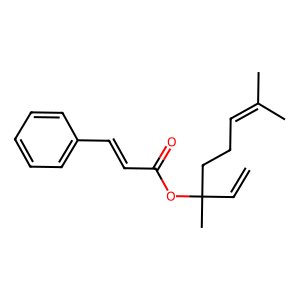

'COC(=O)CC(=O)C(C)(C)C'

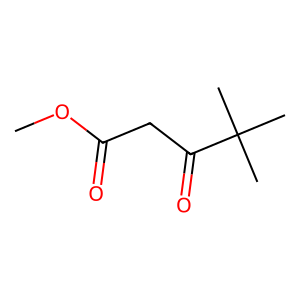

'CC1=CC(N)=CC=C1'

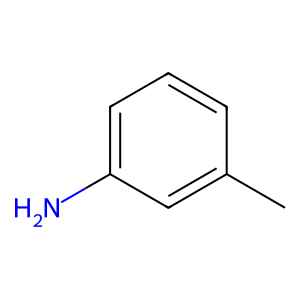

In [5]:
smiles_list = ["CC(C)=CCCC(C)(OC(=O)C=CC1=CC=CC=C1)C=C", "COC(=O)CC(=O)C(C)(C)C", "CC1=CC(N)=CC=C1"]

for s in smiles_list:
    mol = Chem.MolFromSmiles(s)
    img = Draw.MolToImage(mol)
    display(s, img)

### Visualize 3D molecular structures

In [6]:
# for s in smiles_list:
#     mol = Chem.MolFromSmiles(s)
#     mol = Chem.AddHs(mol)
#     AllChem.EmbedMolecule(mol)
#     AllChem.UFFOptimizeMolecule(mol)

#     # Convert to MOL block for 3Dmol.js
#     block = Chem.MolToMolBlock(mol)

#     # Show with py3Dmol
#     viewer = py3Dmol.view(width=400, height=400)
#     viewer.addModel(block, "mol")
#     viewer.setStyle({'stick': {}})
#     viewer.zoomTo()
#     viewer.show()

### Descriptors 

#### E-state indices
- **MaxAbsEStateIndex**: Maximum absolute E-State value for any atom
- **MaxEStateIndex**: Maximum E-State value for any atom
- **MinAbsEStateIndex**: Minimum absolute E-State value for any atom
- **MinEStateIndex**: Minimum E-State value for any atom

#### Drug-likeness properties
- **qed**: Quantitative Estimate of Drug-likeness
- **SPS**: Synthetic accessibility score

#### Basic molecular properties
- **MolWt**: Molecular weight
- **HeavyAtomMolWt**: Molecular weight excluding hydrogens
- **ExactMolWt**: Exact molecular weight calculated from isotope masses
- **NumValenceElectrons**: Number of valence electrons
- **NumRadicalElectrons**: Number of radical electrons
- **HeavyAtomCount**: Count of non-hydrogen atoms

#### Charge-related properties
- **MaxPartialCharge**: Maximum partial charge
- **MinPartialCharge**: Minimum partial charge
- **MaxAbsPartialCharge**: Maximum absolute partial charge
- **MinAbsPartialCharge**: Minimum absolute partial charge

#### Fingerprint density
- **FpDensityMorgan1**: Fingerprint density for Morgan fingerprints of radius 1
- **FpDensityMorgan2**: Fingerprint density for Morgan fingerprints of radius 2
- **FpDensityMorgan3**: Fingerprint density for Morgan fingerprints of radius 3

#### BCUT descriptors
- **BCUT2D_MWHI**: Highest eigenvalue from atomic weight weighted distance matrix
- **BCUT2D_MWLOW**: Lowest eigenvalue from atomic weight weighted distance matrix
- **BCUT2D_CHGHI**: Highest eigenvalue from charge weighted distance matrix
- **BCUT2D_CHGLO**: Lowest eigenvalue from charge weighted distance matrix
- **BCUT2D_LOGPHI**: Highest eigenvalue from LogP weighted distance matrix
- **BCUT2D_LOGPLOW**: Lowest eigenvalue from LogP weighted distance matrix
- **BCUT2D_MRHI**: Highest eigenvalue from molar refractivity weighted distance matrix
- **BCUT2D_MRLOW**: Lowest eigenvalue from molar refractivity weighted distance matrix

#### Molecular complexity and topology
- **AvgIpc**: Average information content based on principal moments of inertia
- **BalabanJ**: Balaban's J index (topological distance connectivity index)
- **BertzCT**: Bertz complexity index
- **Ipc**: Information content based on the principal moments of inertia
- **Phi**: Molecular flexibility index

#### Chi connectivity indices
- **Chi0/Chi0n/Chi0v**: Simple connectivity index (order 0, with variants)
- **Chi1/Chi1n/Chi1v**: Simple connectivity index (order 1, with variants)
- **Chi2n/Chi2v**: Simple connectivity index (order 2, with variants)
- **Chi3n/Chi3v**: Simple connectivity index (order 3, with variants)
- **Chi4n/Chi4v**: Simple connectivity index (order 4, with variants)

#### Kappa shape indices
- **HallKierAlpha**: Hall-Kier alpha value
- **Kappa1**: First kappa shape index
- **Kappa2**: Second kappa shape index
- **Kappa3**: Third kappa shape index

#### Surface area descriptors
- **LabuteASA**: Labute's Approximate Surface Area
- **TPSA**: Topological Polar Surface Area

#### VSA type descriptors
- **PEOE_VSA1-14**: 14 descriptors using partial charges and surface area
- **SMR_VSA1-10**: 10 descriptors using molar refractivity and surface area
- **SlogP_VSA1-12**: 12 descriptors using LogP and surface area
- **EState_VSA1-11**: 11 descriptors using EState indices and surface area
- **VSA_EState1-10**: 10 more descriptors based on EState values and surface area

#### Atom-type counts
- **FractionCSP3**: Fraction of C atoms that are sp3 hybridized
- **NHOHCount**: Number of NHs or OHs
- **NOCount**: Number of Nitrogen and Oxygen atoms

#### Ring properties
- **NumAliphaticCarbocycles**: Count of aliphatic carbocycles
- **NumAliphaticHeterocycles**: Count of aliphatic heterocycles
- **NumAliphaticRings**: Count of aliphatic rings
- **NumAromaticCarbocycles**: Count of aromatic carbocycles
- **NumAromaticHeterocycles**: Count of aromatic heterocycles
- **NumAromaticRings**: Count of aromatic rings
- **NumHeterocycles**: Count of heterocycles
- **NumSaturatedCarbocycles**: Count of saturated carbocycles
- **NumSaturatedHeterocycles**: Count of saturated heterocycles
- **NumSaturatedRings**: Count of saturated rings
- **RingCount**: Total ring count

#### Stereochemistry
- **NumAtomStereoCenters**: Number of stereocenters
- **NumUnspecifiedAtomStereoCenters**: Number of unspecified stereocenters
- **NumBridgeheadAtoms**: Number of bridgehead atoms (atoms shared by multiple rings)
- **NumSpiroAtoms**: Number of spiro atoms (atoms connecting two rings)

#### Hydrogen Bonding
- **NumHAcceptors**: Number of hydrogen bond acceptors
- **NumHDonors**: Number of hydrogen bond donors

#### Other molecular properties
- **NumAmideBonds**: Count of amide bonds
- **NumHeteroatoms**: Count of atoms that are not C or H
- **NumRotatableBonds**: Count of rotatable bonds
- **MolLogP**: Wildman-Crippen LogP value (lipophilicity)
- **MolMR**: Wildman-Crippen Molar Refractivity

#### Functional group counts (fr_ prefixed)
- **fr_Al_COO**: Count of aliphatic carboxylic acids
- **fr_Al_OH**: Count of aliphatic hydroxyl groups
- **fr_Al_OH_noTert**: Count of aliphatic hydroxyl groups excluding tertiary alcohols
- **fr_ArN**: Count of N aromatic bonds
- **fr_Ar_COO**: Count of aromatic carboxylic acids
- **fr_Ar_N**: Count of aromatic nitrogens
- **fr_Ar_NH**: Count of aromatic amines
- **fr_Ar_OH**: Count of aromatic hydroxyl groups
- **fr_COO**: Count of carboxylic acids
- **fr_COO2**: Count of carboxylic acid derivatives
- **fr_C_O**: Count of carbonyl O
- **fr_C_O_noCOO**: Count of carbonyl O, excluding carboxylic acids and derivatives
- **fr_C_S**: Count of thiocarbonyl
- **fr_HOCCN**: Count of C(OH)CCN-Ctert-alkyl or C(OH)CCNcyclic
- **fr_Imine**: Count of imines
- **fr_NH0**: Count of tertiary amines
- **fr_NH1**: Count of secondary amines
- **fr_NH2**: Count of primary amines
- **fr_N_O**: Count of hydroxylamine groups
- **fr_Ndealkylation1**: Count of groups that can undergo dealkylation
- **fr_Ndealkylation2**: Count of groups that can undergo dealkylation (version 2)
- **fr_Nhpyrrole**: Count of H-pyrrole nitrogens
- **fr_SH**: Count of thiol groups
- **fr_aldehyde**: Count of aldehyde groups
- **fr_alkyl_carbamate**: Count of alkyl carbamates
- **fr_alkyl_halide**: Count of alkyl halides
- **fr_allylic_oxid**: Count of allylic oxidation sites
- **fr_amide**: Count of amide groups
- **fr_amidine**: Count of amidine groups
- **fr_aniline**: Count of anilines
- **fr_aryl_methyl**: Count of aryl methyl groups
- **fr_azide**: Count of azide groups
- **fr_azo**: Count of azo groups
- **fr_barbitur**: Count of barbiturate groups
- **fr_benzene**: Count of benzene rings
- **fr_benzodiazepine**: Count of benzodiazepine groups
- **fr_bicyclic**: Count of bicyclic structures
- **fr_diazo**: Count of diazo groups
- **fr_dihydropyridine**: Count of dihydropyridines
- **fr_epoxide**: Count of epoxide rings
- **fr_ester**: Count of ester groups
- **fr_ether**: Count of ether groups
- **fr_furan**: Count of furan rings
- **fr_guanido**: Count of guanidine groups
- **fr_halogen**: Count of halogens
- **fr_hdrzine**: Count of hydrazine groups
- **fr_hdrzone**: Count of hydrazone groups
- **fr_imidazole**: Count of imidazole rings
- **fr_imide**: Count of imide groups
- **fr_isocyan**: Count of isocyanates
- **fr_isothiocyan**: Count of isothiocyanates
- **fr_ketone**: Count of ketone groups
- **fr_ketone_Topliss**: Count of ketones excluding diaryl, a,b-unsaturated
- **fr_lactam**: Count of lactam groups
- **fr_lactone**: Count of lactone groups
- **fr_methoxy**: Count of methoxy groups
- **fr_morpholine**: Count of morpholine rings
- **fr_nitrile**: Count of nitrile groups
- **fr_nitro**: Count of nitro groups
- **fr_nitro_arom**: Count of nitro groups attached to aromatics
- **fr_nitro_arom_nonortho**: Count of nitro groups attached to aromatics (non-ortho)
- **fr_nitroso**: Count of nitroso groups
- **fr_oxazole**: Count of oxazole rings
- **fr_oxime**: Count of oxime groups
- **fr_para_hydroxylation**: Count of para-hydroxylation sites
- **fr_phenol**: Count of phenol groups
- **fr_phenol_noOrthoHbond**: Count of phenols that can't form intramolecular H-bonds
- **fr_phos_acid**: Count of phosphoric acid groups
- **fr_phos_ester**: Count of phosphoric ester groups
- **fr_piperdine**: Count of piperidine rings
- **fr_piperzine**: Count of piperazine rings
- **fr_priamide**: Count of primary amides
- **fr_prisulfonamd**: Count of primary sulfonamides
- **fr_pyridine**: Count of pyridine rings
- **fr_quatN**: Count of quaternary nitrogens
- **fr_sulfide**: Count of sulfide groups
- **fr_sulfonamd**: Count of sulfonamides
- **fr_sulfone**: Count of sulfone groups
- **fr_term_acetylene**: Count of terminal acetylenes
- **fr_tetrazole**: Count of tetrazole rings
- **fr_thiazole**: Count of thiazole rings
- **fr_thiocyan**: Count of thiocyanates
- **fr_thiophene**: Count of thiophene rings
- **fr_unbrch_alkane**: Count of unbranched alkanes of at least 4 members
- **fr_urea**: Count of urea groups

In [7]:
%%time


def compute_all_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [None] * len(desc_names)
    return [desc[1](mol) for desc in Descriptors.descList]


desc_names = [desc[0] for desc in Descriptors.descList]
descriptors = [compute_all_descriptors(smi) for smi in train["smiles"].to_list()]
descriptors = pd.DataFrame(descriptors, columns=desc_names)
descriptors.to_csv("df_descriptors.csv", index=False)

CPU times: user 1min 36s, sys: 27.3 s, total: 2min 3s
Wall time: 1min 16s


In [8]:
display(descriptors.shape)
display(descriptors.head())

(7692, 217)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.497683,12.497683,0.204801,-4.503717,0.374423,30.818182,520.390,488.134,519.134430,184,...,0,0,0,0,0,0,0,0,0,0
1,10.341432,10.341432,0.086944,-0.424167,0.510667,10.333333,163.136,158.096,163.038176,60,...,0,0,0,0,0,0,0,0,0,0
2,4.134259,4.134259,0.971898,0.971898,0.561502,9.555556,122.171,112.091,122.084398,48,...,0,0,0,0,0,0,0,0,0,0
3,13.613482,13.613482,0.008730,-0.830196,0.076652,13.750000,844.450,785.986,843.397391,322,...,0,0,0,0,0,0,0,0,0,0
4,12.393224,12.393224,0.007174,-0.235913,0.557318,20.153846,391.294,371.134,390.078950,136,...,0,0,0,0,0,0,0,0,0,0


### Fingerprints
- Morgan Fingerprints (also known as Extended Connectivity Fingerprints or ECFPs). 
- Starting at each atom in the molecule.
- Iteratively expanding outward to capture circular "neighborhoods" around each atom.
- The radius parameter (2, or 3 or 4 in your list) determines how many bonds away from the central atom the fingerprint looks.
- Each unique substructure (or subgraph) gets hashed to a bit position in the fingerprint.
- Apply `TruncatedSVD` for dimensionality reduction.

In [9]:
%%time


def get_morgan_fp(smiles, radius=4, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr


ecfp = [get_morgan_fp(smi, radius=2) for smi in train["smiles"].to_list()]
ecfp_svd_2 = TruncatedSVD(n_components=n_components, algorithm="arpack", random_state=42)
ecfp_svd_2 = pd.DataFrame(ecfp_svd_2.fit_transform(ecfp))
ecfp_svd_2.columns = [f"ecfp_svd_{j}" for j in range(n_components)]
ecfp_svd_2.to_csv("df_ecfp_svd_2.csv", index=False)

ecfp = [get_morgan_fp(smi, radius=3) for smi in train["smiles"].to_list()]
ecfp_svd_3 = TruncatedSVD(n_components=n_components, algorithm="arpack", random_state=42)
ecfp_svd_3 = pd.DataFrame(ecfp_svd_3.fit_transform(ecfp))
ecfp_svd_3.columns = [f"ecfp_svd_{j}" for j in range(n_components)]
ecfp_svd_3.to_csv("df_ecfp_svd_3.csv", index=False)

ecfp = [get_morgan_fp(smi, radius=4) for smi in train["smiles"].to_list()]
ecfp_svd_4 = TruncatedSVD(n_components=n_components, algorithm="arpack", random_state=42)
ecfp_svd_4 = pd.DataFrame(ecfp_svd_4.fit_transform(ecfp))
ecfp_svd_4.columns = [f"ecfp_svd_{j}" for j in range(n_components)]
ecfp_svd_4.to_csv("df_ecfp_svd_4.csv", index=False)

CPU times: user 22.3 s, sys: 9.95 s, total: 32.2 s
Wall time: 13.8 s


In [10]:
display(ecfp_svd_2.shape)
display(ecfp_svd_2.head())

(7692, 10)

,ecfp_svd_0,ecfp_svd_1,ecfp_svd_2,ecfp_svd_3,ecfp_svd_4,ecfp_svd_5,ecfp_svd_6,ecfp_svd_7,ecfp_svd_8,ecfp_svd_9
0,3.698817,-0.203937,1.918085,-0.037202,-0.855865,1.158497,-1.123316,0.136474,0.702756,0.499439
1,1.732393,1.313129,0.067224,-0.233333,-1.258969,-1.133416,-0.268831,0.018502,-0.529576,0.291877
2,1.581984,-0.038373,-0.283679,-1.254344,-0.450790,-0.132762,0.321742,-0.166950,-0.442782,-0.065822
3,4.764513,-0.434445,-0.952423,-0.449292,0.463913,0.532624,0.429486,1.772339,1.341011,1.230383
4,3.677944,0.340813,-0.031828,0.685967,0.452096,0.939780,-0.920062,-0.009694,0.616314,-0.043164


### TF-IDF 
- TF-IDF (Term Frequency–Inverse Document Frequency) is a numerical statistic used to represent how important a word or token is in a collection of documents.
- Treat each SMILES string as a "sentence" and its characters as "tokens".
- Create multiple models with different `n_gram` and `min_df`.
- Create both raw features and `TruncatedSVD` for dimensionality reduction,

In [11]:
%%time


def create_tfidf_features(train, n_gram, min_df):
    tfidf_vec = TfidfVectorizer(
        analyzer="char",
        encoding="utf-8",
        ngram_range=(1, n_gram),
        decode_error="ignore",
        min_df=min_df,
    )
    text_tfidf = tfidf_vec.fit_transform(train["smiles"].tolist())
    feature_names = tfidf_vec.get_feature_names_out()
    tfidf = pd.DataFrame(text_tfidf.todense())
    tfidf.columns = [f"tfidf_{j}" for j in range(len(feature_names))]

    return tfidf, feature_names


def create_tfidf_svd_features(train, n_gram, min_df):
    tfidf_vec = TfidfVectorizer(
        analyzer="char",
        encoding="utf-8",
        ngram_range=(1, n_gram),
        decode_error="ignore",
        min_df=min_df,
    )
    text_tfidf = tfidf_vec.fit_transform(train["smiles"].tolist())
    tfidf_svd = TruncatedSVD(n_components=n_components, algorithm="arpack", random_state=42)
    tfidf_svd = pd.DataFrame(tfidf_svd.fit_transform(text_tfidf))
    tfidf_svd.columns = [f"svd_tfidf_{j}" for j in range(n_components)]

    return tfidf_svd


n_gram = 3
min_df = 5
tfidf_3_gram, feature_names = create_tfidf_features(train, n_gram, min_df)
tfidf_3_gram.to_csv("df_tfidf_3_gram.csv", index=False)
tfidf_3_gram_feature_names = pd.DataFrame(feature_names)
tfidf_3_gram_feature_names.columns = ["feature_name"]
tfidf_3_gram_feature_names.to_csv(
    "tfidf_3_gram_feature_names.csv", index=False
)  # save tokens label encoder lookup table

n_gram = 8
min_df = 100
tfidf_8_gram, feature_names = create_tfidf_features(train, n_gram, min_df)
tfidf_8_gram.to_csv("df_tfidf_8_gram.csv", index=False)
tfidf_8_gram_feature_names = pd.DataFrame(feature_names)
tfidf_8_gram_feature_names.columns = ["feature_name"]
tfidf_8_gram_feature_names.to_csv(
    "tfidf_8_gram_feature_names.csv", index=False
)  # save tokens label encoder lookup table

n_gram = 3
min_df = 5
tfidf_svd_3_gram = create_tfidf_svd_features(train, n_gram, min_df)
tfidf_svd_3_gram.to_csv("df_tfidf_svd_3_gram.csv", index=False)

n_gram = 8
min_df = 100
tfidf_svd_8_gram = create_tfidf_svd_features(train, n_gram, min_df)
tfidf_svd_8_gram.to_csv("df_tfidf_svd_8_gram.csv", index=False)

CPU times: user 18 s, sys: 2.53 s, total: 20.6 s
Wall time: 17.6 s


In [12]:
display(tfidf_3_gram.shape)
display(tfidf_3_gram.head())

(7692, 1336)

,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,...,tfidf_1326,tfidf_1327,tfidf_1328,tfidf_1329,tfidf_1330,tfidf_1331,tfidf_1332,tfidf_1333,tfidf_1334,tfidf_1335
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
tfidf_3_gram_feature_names

,feature_name
0,#
1,#c
2,#c)
3,#cc
4,#n
...,...
1331,t
1332,t]
1333,z
1334,zn


In [14]:
display(tfidf_svd_3_gram.shape)
display(tfidf_svd_3_gram.head())

(7692, 10)

,svd_tfidf_0,svd_tfidf_1,svd_tfidf_2,svd_tfidf_3,svd_tfidf_4,svd_tfidf_5,svd_tfidf_6,svd_tfidf_7,svd_tfidf_8,svd_tfidf_9
0,0.547103,0.653285,0.041435,-0.065332,-0.104164,0.114358,-0.063852,-0.006533,-0.025853,0.038122
1,0.523028,0.044268,-0.219866,-0.081883,0.421747,0.084364,0.036427,-0.053552,0.068797,-0.016572
2,0.554075,-0.151710,-0.018648,-0.226250,0.060500,0.063265,0.102479,0.217439,0.128148,-0.146667
3,0.873217,-0.085743,0.035836,0.056719,-0.067784,-0.035608,0.043798,0.093399,0.071998,0.104321
4,0.816631,-0.129703,-0.140475,-0.010063,-0.155627,0.169420,-0.077335,-0.064193,0.010502,0.090873


### ChemBERTa embeddings features
- Model family: RoBERTa (BERT variant) trained on SMILES.
- Pretrained dataset: Typically trained on PubChem or ChEMBL SMILES.
- Uses: Generate embeddings for QSAR, virtual screening, toxicity prediction, etc.
- Platform: Available on HuggingFace as `seyonec/ChemBERTa-zinc-base-v1`.
- Apply PCA for dimensionality reduction.

In [15]:
%%time


def get_chemberta_emb(smiles):
    inputs = tokenizer(smiles, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden = outputs.last_hidden_state  # shape: [1, seq_len, hidden_dim]
    avg_embedding = last_hidden[0].mean(dim=0).numpy()
    return avg_embedding


model_name = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

chemberta_emb = [get_chemberta_emb(smi) for smi in train["smiles"].to_list()]
chemberta_emb_pca = PCA(n_components=n_components)

chemberta_emb_pca = pd.DataFrame(chemberta_emb_pca.fit_transform(chemberta_emb))
chemberta_emb_pca.columns = [f"pca_chemberta_emb_{j}" for j in range(n_components)]
chemberta_emb_pca.to_csv("df_chemberta_emb_pca.csv", index=False)

CPU times: user 12min 56s, sys: 1.63 s, total: 12min 58s
Wall time: 3min 15s


In [16]:
display(chemberta_emb_pca.shape)
display(chemberta_emb_pca.head())

(7692, 10)

,pca_chemberta_emb_0,pca_chemberta_emb_1,pca_chemberta_emb_2,pca_chemberta_emb_3,pca_chemberta_emb_4,pca_chemberta_emb_5,pca_chemberta_emb_6,pca_chemberta_emb_7,pca_chemberta_emb_8,pca_chemberta_emb_9
0,-0.966972,3.888116,5.333614,-4.568952,-0.921751,0.178037,-0.355305,0.365937,-1.208155,0.930707
1,4.604345,-4.344881,-0.107021,-1.559606,-0.388810,2.505914,-2.107684,0.046549,1.181279,-1.702014
2,7.081560,-5.527530,-0.469044,-2.855137,-1.026902,-1.505889,-0.715356,1.779835,2.081924,1.207174
3,3.236151,5.455290,2.150410,-0.085503,0.996243,-0.603294,1.615580,1.188540,-2.349309,0.774835
4,3.479065,2.664123,1.447048,1.944978,0.903602,1.006842,1.729119,-0.211357,-0.743630,0.959335


### SMILESBERT embeddings features
- Model family: BERT (Bidirectional Encoder Representations from Transformers).
- Uses: Molecular property prediction (e.g. solubility, toxicity), Drug discovery, QSAR modeling, Molecular similarity, and clustering.
- Platform: Available on HuggingFace as JuIm/SMILES_BERT.
- Apply PCA for dimensionality reduction.

In [17]:
def get_smilesbert_emb(smiles):
    inputs = tokenizer(smiles, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden = outputs.last_hidden_state  # shape: [1, seq_len, hidden_dim]
    avg_embedding = last_hidden[0].mean(dim=0).numpy()
    return avg_embedding


model_name = "JuIm/SMILES_BERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

smilesbert_emb = [get_smilesbert_emb(smi) for smi in train["smiles"].to_list()]
smilesbert_emb_pca = PCA(n_components=n_components)

smilesbert_emb_pca = pd.DataFrame(smilesbert_emb_pca.fit_transform(smilesbert_emb))
smilesbert_emb_pca.columns = [f"pca_smilesbert_emb_{j}" for j in range(n_components)]
smilesbert_emb_pca.to_csv("df_smilesbert_emb_pca.csv", index=False)

In [18]:
display(smilesbert_emb_pca.shape)
display(smilesbert_emb_pca.head())

(7692, 10)

,pca_smilesbert_emb_0,pca_smilesbert_emb_1,pca_smilesbert_emb_2,pca_smilesbert_emb_3,pca_smilesbert_emb_4,pca_smilesbert_emb_5,pca_smilesbert_emb_6,pca_smilesbert_emb_7,pca_smilesbert_emb_8,pca_smilesbert_emb_9
0,-0.427654,6.921258,3.356588,-2.174644,-0.930319,2.515231,-1.060579,0.446114,1.161667,0.677742
1,4.107217,-4.431655,3.022689,-2.795345,-0.229595,-1.979840,0.069340,0.170081,-0.972928,-0.281732
2,5.826943,-7.601167,1.486179,-0.432240,0.360856,1.066208,-1.164790,0.000866,0.822241,1.320151
3,3.494062,3.318169,1.430073,2.064711,-2.586368,2.172254,1.030881,0.646447,1.579228,-1.186851
4,4.327878,2.658996,-1.506422,1.043573,-2.290896,0.459812,1.224881,0.150357,0.737758,-0.474594


### Export to CSV format for use with DataRobot

#### Single type of feature

In [19]:
%%time

# descriptors
df_descriptors = pd.read_csv("df_descriptors.csv")
df_descriptors = pd.concat([train[["moleculer", target]], df_descriptors], axis=1)
df_descriptors.to_csv("descriptors.csv", index=False)

# ecfp_svd_2
df_ecfp_svd_2 = pd.read_csv("df_ecfp_svd_2.csv")
df_ecfp_svd_2 = pd.concat([train[["moleculer", target]], df_ecfp_svd_2], axis=1)
df_ecfp_svd_2.to_csv("ecfp_svd_2.csv", index=False)

# ecfp_svd_3
df_ecfp_svd_3 = pd.read_csv("df_ecfp_svd_3.csv")
df_ecfp_svd_3 = pd.concat([train[["moleculer", target]], df_ecfp_svd_3], axis=1)
df_ecfp_svd_3.to_csv("ecfp_svd_3.csv", index=False)

# ecfp_svd_4
df_ecfp_svd_4 = pd.read_csv("df_ecfp_svd_4.csv")
df_ecfp_svd_4 = pd.concat([train[["moleculer", target]], df_ecfp_svd_4], axis=1)
df_ecfp_svd_4.to_csv("ecfp_svd_4.csv", index=False)

# tfidf_3_gram
df_tfidf_3_gram = pd.read_csv("df_tfidf_3_gram.csv")
df_tfidf_3_gram = pd.concat([train[["moleculer", target]], df_tfidf_3_gram], axis=1)
df_tfidf_3_gram.to_csv("tfidf_3_gram.csv", index=False)

# tfidf_8_gram
df_tfidf_8_gram = pd.read_csv("df_tfidf_8_gram.csv")
df_tfidf_8_gram = pd.concat([train[["moleculer", target]], df_tfidf_8_gram], axis=1)
df_tfidf_8_gram.to_csv("tfidf_8_gram.csv", index=False)

# tfidf_svd_3_gram
df_tfidf_svd_3_gram = pd.read_csv("df_tfidf_svd_3_gram.csv")
df_tfidf_svd_3_gram = pd.concat([train[["moleculer", target]], df_tfidf_svd_3_gram], axis=1)
df_tfidf_svd_3_gram.to_csv("tfidf_svd_3_gram.csv", index=False)

# tfidf_svd_8_gram
df_tfidf_svd_8_gram = pd.read_csv("df_tfidf_svd_8_gram.csv")
df_tfidf_svd_8_gram = pd.concat([train[["moleculer", target]], df_tfidf_svd_8_gram], axis=1)
df_tfidf_svd_8_gram.to_csv("tfidf_svd_8_gram.csv", index=False)

# df_chemberta_emb_pca
df_chemberta_emb_pca = pd.read_csv("df_chemberta_emb_pca.csv")
df_chemberta_emb_pca = pd.concat([train[["moleculer", target]], df_chemberta_emb_pca], axis=1)
df_chemberta_emb_pca.to_csv("chemberta_emb_pca.csv", index=False)

# df_smilesbert_emb_pca
df_smilesbert_emb_pca = pd.read_csv("df_smilesbert_emb_pca.csv")
df_smilesbert_emb_pca = pd.concat([train[["moleculer", target]], df_smilesbert_emb_pca], axis=1)
df_smilesbert_emb_pca.to_csv("smilesbert_emb_pca.csv", index=False)

CPU times: user 20.5 s, sys: 510 ms, total: 21 s
Wall time: 21.1 s


#### Combine several features

In [20]:
%%time

df_descriptors = pd.read_csv("df_descriptors.csv")
df_ecfp_svd_3 = pd.read_csv("df_ecfp_svd_3.csv")
df_tfidf_8_gram = pd.read_csv("df_tfidf_8_gram.csv")
df_chemberta_emb_pca = pd.read_csv("df_chemberta_emb_pca.csv")

# descriptors_ecfp
descriptors_ecfp = pd.concat([train[["moleculer", target]], df_descriptors, df_ecfp_svd_3], axis=1)
descriptors_ecfp.to_csv("descriptors_ecfp.csv", index=False)

# descriptors_ecfp_tfidf
descriptors_ecfp_tfidf = pd.concat(
    [train[["moleculer", target]], df_descriptors, df_ecfp_svd_3, df_tfidf_8_gram], axis=1
)
descriptors_ecfp_tfidf.to_csv("descriptors_ecfp_tfidf.csv", index=False)

# descriptors_ecfp_tfidf_chemberta
descriptors_ecfp_tfidf_chemberta = pd.concat(
    [
        train[["moleculer", target]],
        df_descriptors,
        df_ecfp_svd_3,
        df_tfidf_8_gram,
        df_chemberta_emb_pca,
    ],
    axis=1,
)
descriptors_ecfp_tfidf_chemberta.to_csv("descriptors_ecfp_tfidf_chemberta.csv", index=False)

CPU times: user 25.5 s, sys: 770 ms, total: 26.3 s
Wall time: 26.8 s


### Create a Use Case

Create a Use Case and then build a model for each feature set.

In [21]:
%%time


def __run_autopilot(
    use_case,
    blueprint_name,
    dataset,
    target,
    group_col,
    regression,
    class_num,
    cv,
    project_name,
    holdout_pct,
    seed,
):
    project = dr.Project.create_from_dataset(
        dataset_id=dataset.id, project_name=project_name, use_case=use_case
    )

    ao = dr.AdvancedOptions(seed=seed)

    if group_col != False:
        pm = dr.GroupCV(holdout_pct=holdout_pct, partition_key_cols=[group_col], reps=cv)
    elif regression == False:
        if class_num == 2:
            pm = dr.StratifiedCV(holdout_pct=holdout_pct, reps=cv)
        else:
            pm = dr.RandomCV(holdout_pct=holdout_pct, reps=cv)
    elif regression == True:
        pm = dr.RandomCV(holdout_pct=holdout_pct, reps=cv)

    project.analyze_and_model(
        worker_count=-1,
        target=target,
        mode="manual",
        partitioning_method=pm,
        advanced_options=ao,
        max_wait=100000,
    )

    blueprints = project.get_blueprints()
    for bp in blueprints:
        if str(bp) == blueprint_name:
            print(bp, bp.id)
            bp_id = bp.id
            break

    model_job_id = project.train(bp_id)
    new_model = wait_for_async_model_creation(
        project_id=project.id,
        model_job_id=model_job_id,
    )

    new_model.cross_validate()

    return new_model


use_case = dr.UseCase.create(project_name)
dataset_1 = dr.Dataset.create_from_file("descriptors.csv")
dataset_2 = dr.Dataset.create_from_file("ecfp_svd_2.csv")
dataset_3 = dr.Dataset.create_from_file("ecfp_svd_3.csv")
dataset_4 = dr.Dataset.create_from_file("ecfp_svd_4.csv")
dataset_5 = dr.Dataset.create_from_file("tfidf_3_gram.csv")
dataset_6 = dr.Dataset.create_from_file("tfidf_8_gram.csv")
dataset_7 = dr.Dataset.create_from_file("tfidf_svd_3_gram.csv")
dataset_8 = dr.Dataset.create_from_file("tfidf_svd_8_gram.csv")
dataset_9 = dr.Dataset.create_from_file("chemberta_emb_pca.csv")
dataset_10 = dr.Dataset.create_from_file("smilesbert_emb_pca.csv")
dataset_11 = dr.Dataset.create_from_file("descriptors_ecfp.csv")
dataset_12 = dr.Dataset.create_from_file("descriptors_ecfp_tfidf.csv")
dataset_13 = dr.Dataset.create_from_file("descriptors_ecfp_tfidf_chemberta.csv")

use_case.add(entity=dataset_1)
use_case.add(entity=dataset_2)
use_case.add(entity=dataset_3)
use_case.add(entity=dataset_4)
use_case.add(entity=dataset_5)
use_case.add(entity=dataset_6)
use_case.add(entity=dataset_7)
use_case.add(entity=dataset_8)
use_case.add(entity=dataset_9)
use_case.add(entity=dataset_10)
use_case.add(entity=dataset_11)
use_case.add(entity=dataset_12)
use_case.add(entity=dataset_13)

# The best-performing model found via experimentation
blueprint_name = "Blueprint(Light Gradient Boosted Trees Classifier with Early Stopping)"

seed = 42
model_1 = __run_autopilot(
    use_case,
    blueprint_name,
    dataset_1,
    target,
    group_col,
    regression,
    class_num,
    cv,
    "descriptors",
    holdout_pct,
    seed,
)
model_2 = __run_autopilot(
    use_case,
    blueprint_name,
    dataset_2,
    target,
    group_col,
    regression,
    class_num,
    cv,
    "ecfp_svd_2",
    holdout_pct,
    seed,
)
model_3 = __run_autopilot(
    use_case,
    blueprint_name,
    dataset_3,
    target,
    group_col,
    regression,
    class_num,
    cv,
    "ecfp_svd_3",
    holdout_pct,
    seed,
)
model_4 = __run_autopilot(
    use_case,
    blueprint_name,
    dataset_4,
    target,
    group_col,
    regression,
    class_num,
    cv,
    "ecfp_svd_4",
    holdout_pct,
    seed,
)
model_5 = __run_autopilot(
    use_case,
    blueprint_name,
    dataset_5,
    target,
    group_col,
    regression,
    class_num,
    cv,
    "tfidf_3_gram",
    holdout_pct,
    seed,
)
model_6 = __run_autopilot(
    use_case,
    blueprint_name,
    dataset_6,
    target,
    group_col,
    regression,
    class_num,
    cv,
    "tfidf_8_gram",
    holdout_pct,
    seed,
)
model_7 = __run_autopilot(
    use_case,
    blueprint_name,
    dataset_7,
    target,
    group_col,
    regression,
    class_num,
    cv,
    "tfidf_svd_3_gram",
    holdout_pct,
    seed,
)
model_8 = __run_autopilot(
    use_case,
    blueprint_name,
    dataset_8,
    target,
    group_col,
    regression,
    class_num,
    cv,
    "tfidf_svd_8_gram",
    holdout_pct,
    seed,
)
model_9 = __run_autopilot(
    use_case,
    blueprint_name,
    dataset_9,
    target,
    group_col,
    regression,
    class_num,
    cv,
    "chemberta_emb_pca",
    holdout_pct,
    seed,
)
model_10 = __run_autopilot(
    use_case,
    blueprint_name,
    dataset_10,
    target,
    group_col,
    regression,
    class_num,
    cv,
    "smilesbert_emb_pca",
    holdout_pct,
    seed,
)
model_11 = __run_autopilot(
    use_case,
    blueprint_name,
    dataset_11,
    target,
    group_col,
    regression,
    class_num,
    cv,
    "descriptors_ecfp",
    holdout_pct,
    seed,
)
model_12 = __run_autopilot(
    use_case,
    blueprint_name,
    dataset_12,
    target,
    group_col,
    regression,
    class_num,
    cv,
    "descriptors_ecfp_tfidf",
    holdout_pct,
    seed,
)
model_13 = __run_autopilot(
    use_case,
    blueprint_name,
    dataset_13,
    target,
    group_col,
    regression,
    class_num,
    cv,
    "descriptors_ecfp_tfidf_chemberta",
    holdout_pct,
    seed,
)

Blueprint(Light Gradient Boosted Trees Classifier with Early Stopping) 199be12fc9b777116f4b9d9ee7fca6bd
Blueprint(Light Gradient Boosted Trees Classifier with Early Stopping) a58b7962fa8c47c5e8f2ecc947f36885
Blueprint(Light Gradient Boosted Trees Classifier with Early Stopping) a58b7962fa8c47c5e8f2ecc947f36885
Blueprint(Light Gradient Boosted Trees Classifier with Early Stopping) a58b7962fa8c47c5e8f2ecc947f36885
Blueprint(Light Gradient Boosted Trees Classifier with Early Stopping) dea57b053e059cc7488bccd8479cc201
Blueprint(Light Gradient Boosted Trees Classifier with Early Stopping) dea57b053e059cc7488bccd8479cc201
Blueprint(Light Gradient Boosted Trees Classifier with Early Stopping) a58b7962fa8c47c5e8f2ecc947f36885
Blueprint(Light Gradient Boosted Trees Classifier with Early Stopping) a58b7962fa8c47c5e8f2ecc947f36885
Blueprint(Light Gradient Boosted Trees Classifier with Early Stopping) a58b7962fa8c47c5e8f2ecc947f36885
Blueprint(Light Gradient Boosted Trees Classifier with Early Sto

### Plot features' contributions (SHAP values)

In [22]:
from datarobot.insights.shap_impact import ShapImpact
from datarobot.insights.shap_matrix import ShapMatrix
from datarobot.insights.shap_preview import ShapPreview

model_id = model_13.id  # or model_id = 'YOUR_MODEL_ID'
# request SHAP Matrix, and wait for it to complete
result = ShapMatrix.create(entity_id=model_id)  # default source is 'validation'
# view the properties of the SHAP Matrix
df = result.get_as_dataframe(entity_id=model_id)

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def get_top_prediction_index(top_p):
    prediction_index = df.sort_values(["prediction_value"])["row_index"].tolist()
    negative_prediction_index = prediction_index[:top_p]
    positive_prediction_index = prediction_index[::-1][:top_p]

    return positive_prediction_index, negative_prediction_index


def get_smiles_shap(index):
    columns = [c for c in df.columns if c not in ["row_index", "prediction_value", "moleculer"]]
    values = df[df["row_index"] == index][columns].values.reshape(-1).tolist()
    prediction_value = df[df["row_index"] == index]["prediction_value"].values[0]
    smiles = train[train.index == index]["smiles"].values[0]

    return smiles, columns, values, prediction_value


def plot_sorted_horizontal_bar_with_labels(
    smiles, columns, values, prediction_value, top_f, positive_impact
):
    # Create and sort DataFrame
    df = pd.DataFrame({"FeatureName": columns, "Contribution": values})
    if positive_impact:
        df = df.sort_values("Contribution", ascending=False).reset_index(drop=True).head(top_f)
    else:
        df = df.sort_values("Contribution", ascending=True).reset_index(drop=True).head(top_f)

    # Plot
    ax = sns.barplot(
        data=df,
        x="Contribution",
        y="FeatureName",
    )

    for container in ax.containers:
        ax.bar_label(container, label_type="center")

    # Add title
    plt.title(smiles + "\nPrediction Value:" + str(prediction_value))

    plt.show()

    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol)
    display(img)

    # mol = Chem.AddHs(mol)
    # AllChem.EmbedMolecule(mol)
    # AllChem.UFFOptimizeMolecule(mol)

    # # Convert to MOL block for 3Dmol.js
    # block = Chem.MolToMolBlock(mol)

    # # Show with py3Dmol
    # viewer = py3Dmol.view(width=400, height=400)
    # viewer.addModel(block, "mol")
    # viewer.setStyle({'stick': {}})
    # viewer.zoomTo()
    # viewer.show()


# maximum and minimum probability
top_p = 5

# top impacted features
top_f = 5

positive_prediction_index, negative_prediction_index = get_top_prediction_index(top_p)

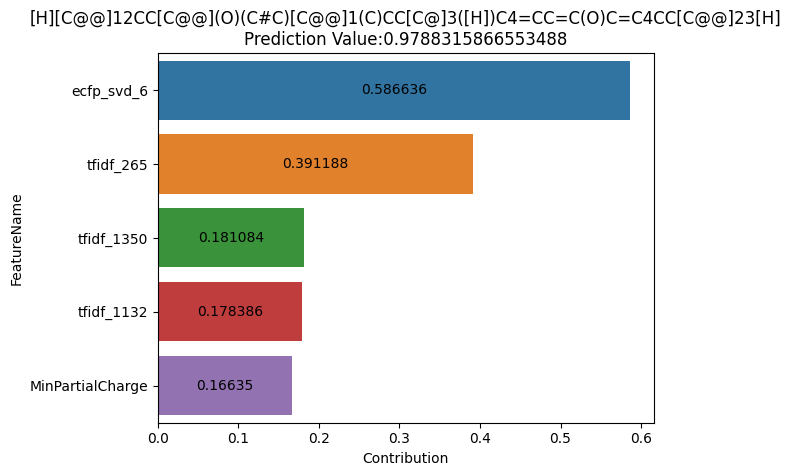

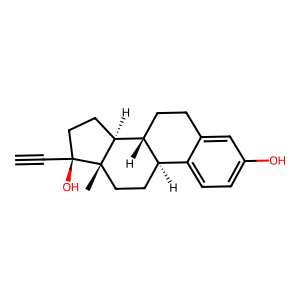

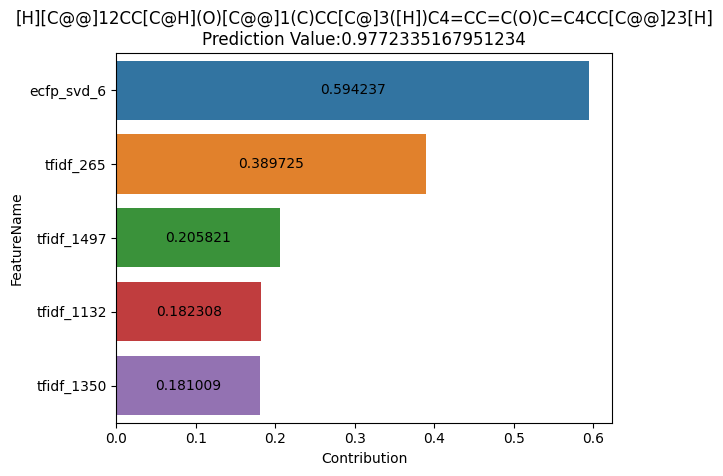

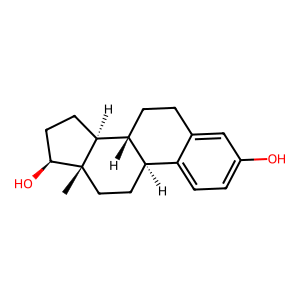

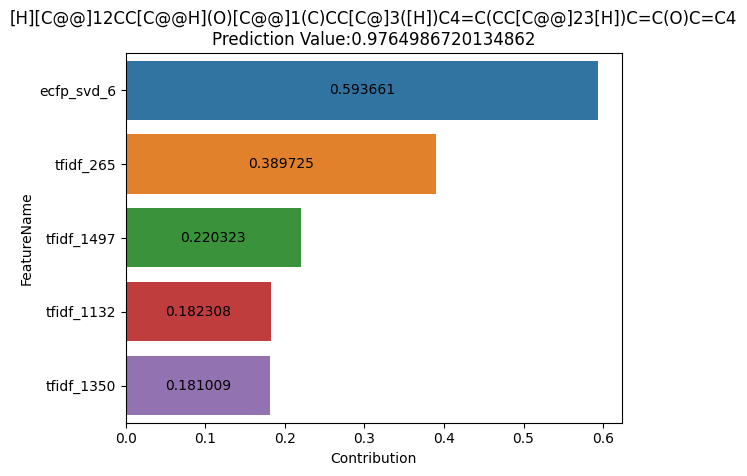

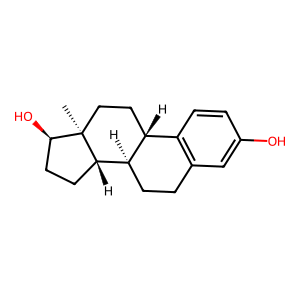

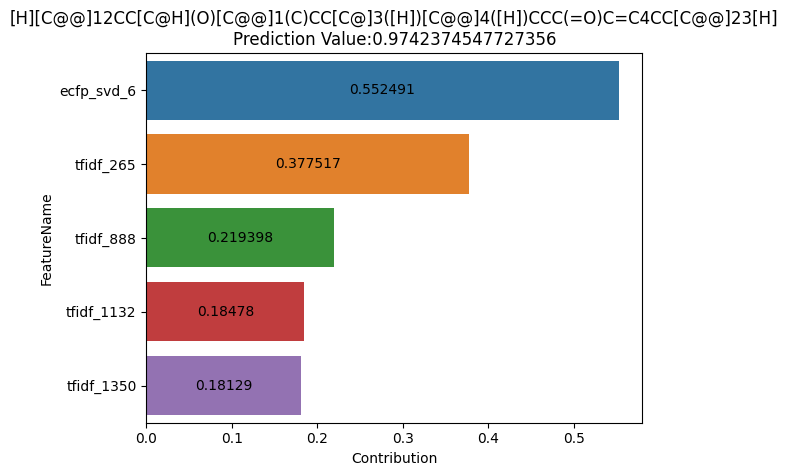

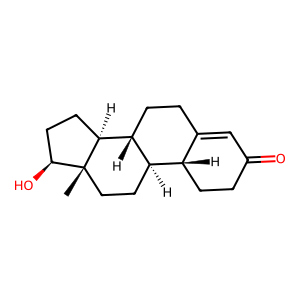

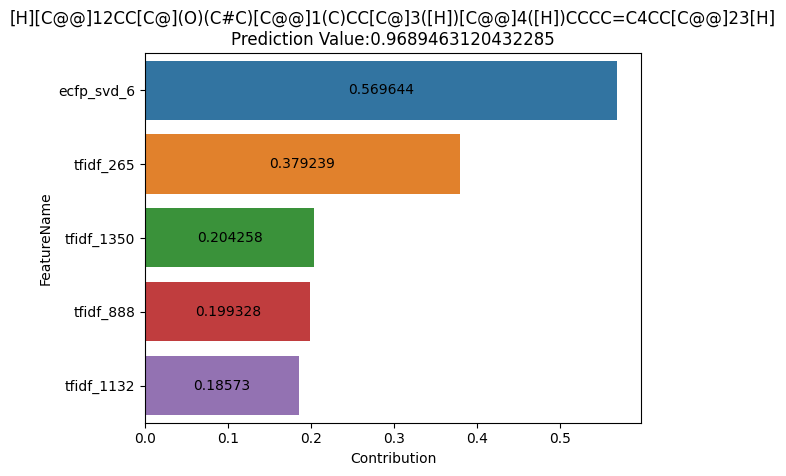

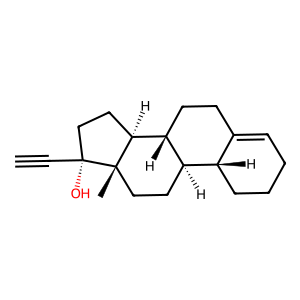

In [24]:
# highest prediction values
for t in range(top_p):
    smiles, columns, values, prediction_value = get_smiles_shap(positive_prediction_index[t])
    plot_sorted_horizontal_bar_with_labels(smiles, columns, values, prediction_value, top_f, True)

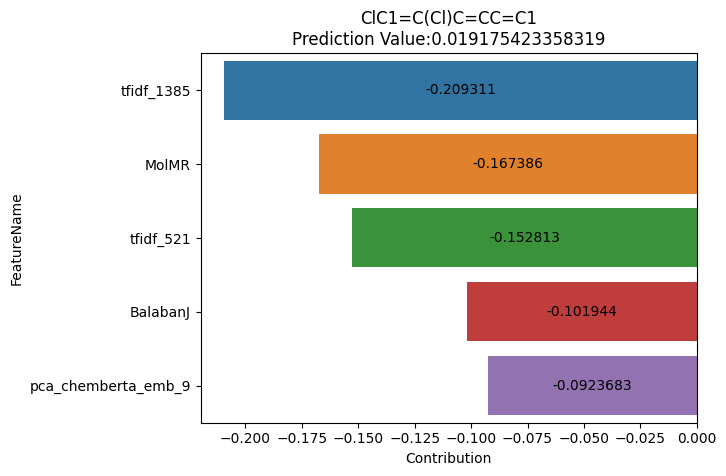

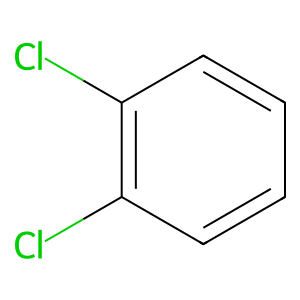

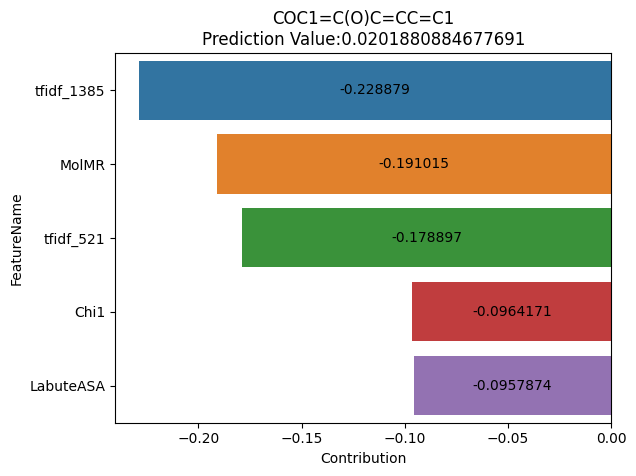

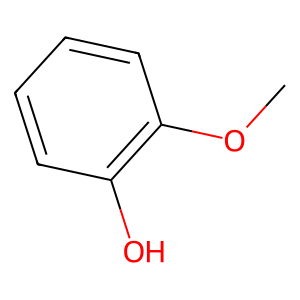

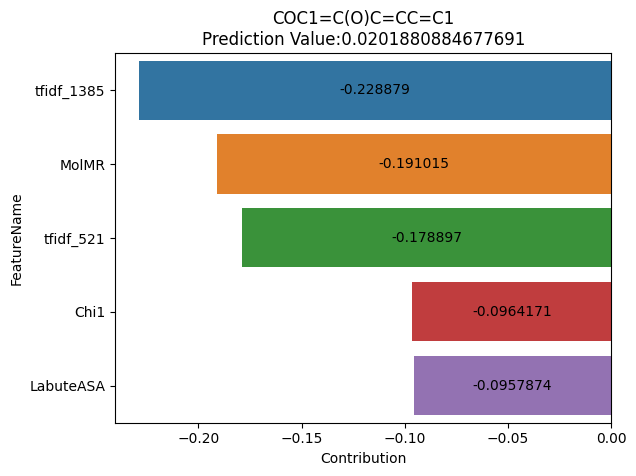

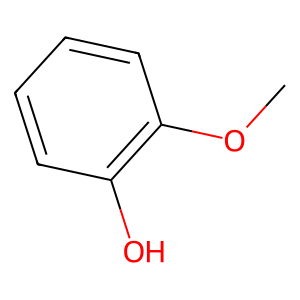

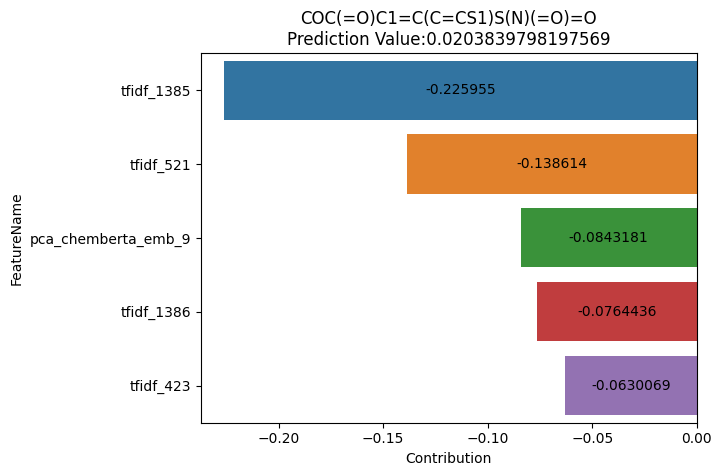

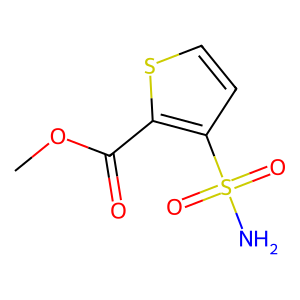

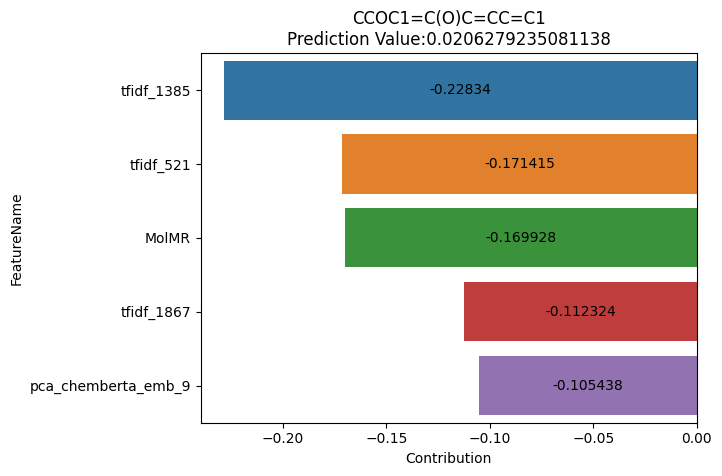

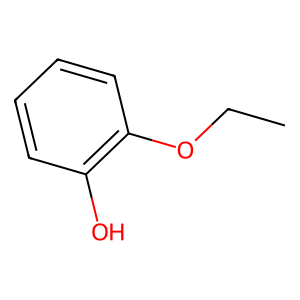

In [25]:
# lowest prediction values
for t in range(top_p):
    smiles, columns, values, prediction_value = get_smiles_shap(negative_prediction_index[t])
    plot_sorted_horizontal_bar_with_labels(smiles, columns, values, prediction_value, top_f, False)